In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt
import math
import datetime
import time
import simpy
import opentnsim.core as core
import pyproj

In [2]:
lat = np.array([52.002240,52.002267,52.002287, 52.002294, 52.002287, 52.002267, 52.002240, 52.002213, 52.002193, 52.002186, 52.002193, 52.002213])
lon = np.array([4.371512,4.371501,4.371469, 4.371425, 4.371381, 4.371349, 4.371338, 4.371349, 4.371381, 4.371425, 4.371469, 4.371501])
coords = []
for lon, lat in zip(lon, lat):
    coords.append([lon, lat])

lat = np.array([52.002240,52.002267,52.002287, 52.002294, 52.002287, 52.002267, 52.002240, 52.002213, 52.002193, 52.002186, 52.002193, 52.002213])
lon = np.array([4.371512,4.371501,4.371469, 4.371425, 4.371381, 4.371349, 4.371338, 4.371349, 4.371381, 4.371425, 4.371469, 4.371501])
coords


[[4.371512, 52.00224],
 [4.371501, 52.002267],
 [4.371469, 52.002287],
 [4.371425, 52.002294],
 [4.371381, 52.002287],
 [4.371349, 52.002267],
 [4.371338, 52.00224],
 [4.371349, 52.002213],
 [4.371381, 52.002193],
 [4.371425, 52.002186],
 [4.371469, 52.002193],
 [4.371501, 52.002213]]

In [3]:
# create a graph 
FG = nx.DiGraph()

# make your preferred Site class out of available mix-ins.
Node = type('Site', (core.Identifiable, core.Locatable), {})

# add nodes
nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]
#path = path.append([nodes[11], nodes[0]])

for index, edge in enumerate(path):
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)



In [4]:
# toggle to undirected and back to directed to make sure all edges are two way traffic
 
FG = FG.to_undirected() 

Number of nodes is 12:
Number of edges is 11:


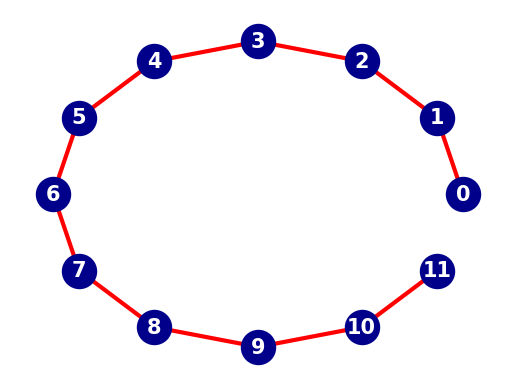

In [9]:
# create a positions dict for the purpose of plotting
positions = {}
for node in FG.nodes:
    positions[node] = (FG.nodes[node]['geometry'].x, FG.nodes[node]['geometry'].y)
    
 # collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

print('Number of nodes is {}:'.format(len(FG.nodes)))
print('Number of edges is {}:'.format(len(FG.edges)))

# draw edges, nodes and labels.
nx.draw_networkx_edges(FG,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()    

In [10]:
# make your preferred Vessel class out of available mix-ins. 
Vessel = type('Vessel', 
              (core.Identifiable, 
               core.Movable), {})

In [11]:
# create a dict with all important settings
data_vessel = {"env": None,          # needed for simpy simulation
               "name": 'Vessel 1',   # required by Identifiable
               "geometry": None,     # required by Locatable
               "route": None,        # required by Routeable
               "v": 1}               # required by Movable

In [12]:
# create an instance of the TransportResource class using the input data dict
vessel = Vessel(**data_vessel)

In [13]:
# create a path along that the vessel needs to follow (in this case from the first node to the last node)
path = nx.dijkstra_path(FG, nodes[0].name, nodes[11].name)


In [14]:
# start simpy environment (specify the start time and add the graph to the environment)
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())
env.FG = FG

# add environment to the vessel, and specify the vessels route and current location (beginning of the path)
vessel.env = env
vessel.route = path
vessel.geometry = env.FG.nodes[path[0]]['geometry']     

# specify the process that needs to be executed
env.process(vessel.move())

# start the simulation
env.run()
print("Simulation of path {} took {} seconds".format(path, int(env.now - env.epoch)))

Simulation of path ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'] took 34 seconds


In [15]:
df = pd.DataFrame.from_dict(vessel.log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node 0 to node 1 start,2022-10-31 14:23:18.000000,0,POINT (4.371512 52.00224)
1,Sailing from node 0 to node 1 start,2022-10-31 14:23:21.097740,0,POINT (4.371501 52.002267)
2,Sailing from node 1 to node 2 start,2022-10-31 14:23:21.097740,0,POINT (4.371501 52.002267)
3,Sailing from node 1 to node 2 start,2022-10-31 14:23:24.225288,0,POINT (4.371469 52.002287)
4,Sailing from node 2 to node 3 start,2022-10-31 14:23:24.225288,0,POINT (4.371469 52.002287)
5,Sailing from node 2 to node 3 start,2022-10-31 14:23:27.345734,0,POINT (4.371425 52.002294)
6,Sailing from node 3 to node 4 start,2022-10-31 14:23:27.345734,0,POINT (4.371425 52.002294)
7,Sailing from node 3 to node 4 start,2022-10-31 14:23:30.466179,0,POINT (4.371381 52.002287)
8,Sailing from node 4 to node 5 start,2022-10-31 14:23:30.466179,0,POINT (4.371381 52.002287)
9,Sailing from node 4 to node 5 start,2022-10-31 14:23:33.593727,0,POINT (4.371349 52.002267)
